In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment import PricingEnvironment
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB

In [2]:
data_gen = BasicDataGenerator(filename='src/basic001.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'{prices=}')
print(f'{bids=}')
print(f'{margins=}')
print(f'{conv_rates=}')
print(f'{costs_per_click=}')
print(f'{n_clicks=}')
print(f'{aggr_tau=}')

sel_bid = 3
print(f'\nSelected bid: {bids[sel_bid]}({sel_bid})')
print(f'Fixed CPC: {costs_per_click[sel_bid]}')
print(f'Fixed num_clicks: {n_clicks[sel_bid]} -> {np.rint(n_clicks[sel_bid]).astype(int)}')
n_arms = len(prices)
env_params = {
        'mode': 'aggregate',
        'src': 'src/basic001.json',
}

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.03, 0.04, 0.07, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0]
margins=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
conv_rates=array([0.213, 0.207, 0.2  , 0.19 , 0.176, 0.16 , 0.132, 0.122, 0.112,
       0.094])
costs_per_click=array([0.03 , 0.04 , 0.069, 0.097, 0.189, 0.44 , 0.626, 0.796, 1.1  ,
       1.367])
n_clicks=array([ 28.807,  37.296,  59.959,  79.058, 124.63 , 183.261, 199.824,
       206.816, 211.296, 212.237])
aggr_tau=array([2.85 , 2.485, 2.12 , 1.755, 1.39 , 1.025, 0.84 , 0.69 , 0.65 ,
       0.65 ])

Selected bid: 0.1(3)
Fixed CPC: 0.097
Fixed num_clicks: 79.058 -> 79


In [3]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [4]:
opt_arm = np.argmax(margins * conv_rates * (1 + aggr_tau) - costs_per_click[sel_bid])
print(f'N_ARMS: {n_arms}')
print(f'Optimal arm: {str(opt_arm)}')

N_ARMS: 10
Optimal arm: 0


In [5]:
learners_to_test = [UCB, ThompsonSampling]
rewards_per_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []

print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')
print(f'ALGORITHMS: {list(rewards_per_experiment.keys())}')

N_ROUNDS: 365
N_EXPERIMENTS: 10
ALGORITHMS: ['UCB-Pricing', 'TS-Pricing']


In [6]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'running exp#{e}...')
    test_instances = []
    for learner in learners_to_test:
        test_instances.append((learner(arm_values=margins), PricingEnvironment(**env_params)))
    for t in range(T):
        for learner, env in test_instances:
            learner.next_day()
            month_purchases = env.get_next_purchases_at_day(t, keep=False)
            if month_purchases is not None:
                pulled_arms = env.get_selected_arms_at_day(t - 30, keep=False)
                for arm, n_purchases in zip(pulled_arms, month_purchases):
                    learner.update_single_future_purchase(arm, n_purchases)
            pulled_arm = learner.pull_arm()
            daily_reward = env.day_round(pulled_arm)
            for outcome, cost in daily_reward:
                learner.update(pulled_arm, outcome, cost)

        for learner, _ in test_instances:
            learner.next_day()
            rewards_per_experiment[learner.LEARNER_NAME].append(learner.daily_collected_rewards)

running exp#0...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#1...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#2...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#3...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#4...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#5...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#6...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#7...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#8...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1
running exp#9...
Environment created with fixed bid: 0.1
Environment created with fixed bid: 0.1


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

<ipython-input-7-3a967294481a>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.cumsum(np.mean(opt - val, axis=0)))


ValueError: operands could not be broadcast together with shapes (3,) (5,) 

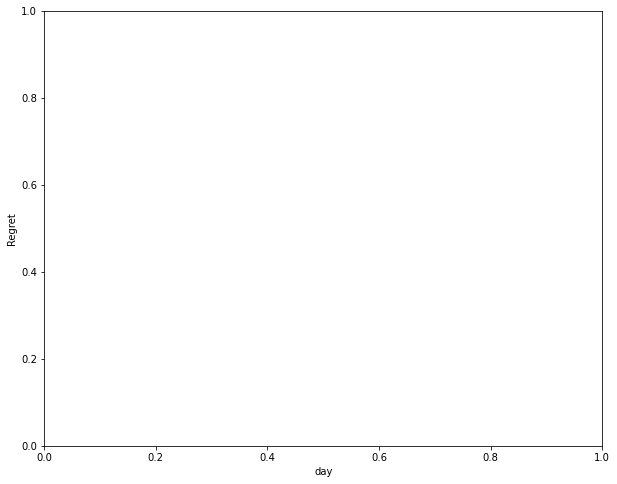

In [7]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
opt = (margins[opt_arm] * conv_rates[opt_arm] * (1 + aggr_tau[opt_arm]) - costs_per_click[sel_bid]) * np.rint(n_clicks[sel_bid]).astype(int)
for val in rewards_per_experiment.values():
    print(val)
    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(rewards_per_experiment.keys())
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*365, '--g', label='clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)
plt.legend(loc='best')
plt.show()